## DA5401 A7: Multi-Class Model Selection using ROC and Precision-Recall Curves  

### Objective  
This assignment focuses on applying and interpreting **Receiver Operating Characteristic (ROC)** and **Precision-Recall Curves (PRC)** for **model selection** in a multi-class classification setting. The goal is to compare several classifiers including intentionally weak ones through careful analysis of their ROC and PRC behavior rather than relying solely on accuracy.

### Problem Statement  
The task involves classifying **land cover types** using the **UCI Landsat Satellite dataset**, a six-class problem known for its **high feature dimensionality** and **class overlap**.  
As a data scientist, the objective is to evaluate and select the most effective classifier using **multi-class ROC** and **PRC analysis**, specifically through the **One-vs-Rest (OvR)** approach.  
The comparison should highlight both **best-performing** and **worst-performing** models while examining their behavior across different **decision thresholds**.


In [1]:
pip install ucimlrepo


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install xgboost



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


### Part A: Data Preparation and Baseline
### 1) Load and Prepare Data

In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
statlog_landsat_satellite = fetch_ucirepo(id=146) 
  
# data (as pandas dataframes) 
X = statlog_landsat_satellite.data.features 
y = statlog_landsat_satellite.data.targets 
  
# metadata 
print(statlog_landsat_satellite.metadata) 
  
# variable information 
print(statlog_landsat_satellite.variables) 


{'uci_id': 146, 'name': 'Statlog (Landsat Satellite)', 'repository_url': 'https://archive.ics.uci.edu/dataset/146/statlog+landsat+satellite', 'data_url': 'https://archive.ics.uci.edu/static/public/146/data.csv', 'abstract': 'Multi-spectral values of pixels in 3x3 neighbourhoods in a satellite image, and the classification associated with the central pixel in each neighbourhood', 'area': 'Climate and Environment', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 6435, 'num_features': 36, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Wed Feb 14 2024', 'dataset_doi': '10.24432/C55887', 'creators': ['Ashwin Srinivasan'], 'intro_paper': None, 'additional_info': {'summary': "The database consists of the multi-spectral values of pixels in 3x3 neighbourhoods in a satellite image, and the classification as


### Standardizing the Landsat dataset features for improved model performance using sklearn's StandardScaler.


In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Dataset is already loaded as X (features), y (target)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


### 2) Train-Test Split
Splitting the standardized data into training and testing sets (75/25 split) using stratification to maintain class balance.

In [5]:
from sklearn.model_selection import train_test_split
y = y.values.ravel()
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42, stratify=y)


Features are now standardized, and the target variable is properly formatted.

### 3) Train All Models  
Training six classifiers on the standardized Landsat dataset: **K-Nearest Neighbors (KNN)**, **Decision Tree**, **Dummy Classifier**, **Logistic Regression**, **Gaussian Naive Bayes**, and **Support Vector Classifier (SVC)** (with probability estimates enabled).


In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

models = {
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Dummy": DummyClassifier(strategy="prior", random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Naive Bayes": GaussianNB(),
    "SVC": SVC(probability=True, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)


### 4) Baseline Evaluation  
Evaluating each trained model by calculating and displaying the **overall accuracy** and **weighted F1-score** to establish baseline performance for the Landsat dataset.


In [7]:
from sklearn.metrics import accuracy_score, f1_score

results = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    results[name] = {"accuracy": acc, "weighted_f1": f1}

results_df = pd.DataFrame(results).T
print(results_df)


                     accuracy  weighted_f1
KNN                  0.910503     0.909546
Decision Tree        0.853947     0.852986
Dummy                0.238036     0.091534
Logistic Regression  0.855811     0.848744
Naive Bayes          0.791175     0.798292
SVC                  0.892480     0.891317


Evaluating all classifiers using **overall accuracy** and **weighted F1-score** on the test set,the results show that the **KNN classifier** achieves the highest accuracy (**0.91**) and weighted F1-score (**0.91**), indicating strong overall performance. The **Dummy classifier** serves as a baseline and performs poorly, emphasizing the improvement provided by the other models.  

Other models — **Decision Tree**, **Logistic Regression**, **Naive Bayes**, and **SVC** also demonstrate reasonably good performance, with **SVC** and **Decision Tree** closely following **KNN** in accuracy and F1-score.


### Part B: ROC Analysis for Model Selection  
#### 1. Multi-Class ROC Calculation (OvR Explanation)  

The **Receiver Operating Characteristic (ROC)** curve illustrates a classifier’s ability to distinguish between classes.  

In **multi-class classification**, the **One-vs-Rest (OvR)** approach converts a K-class problem into **K binary problems**, where each class is treated as *positive* while all others are *negative*. For each class, the **True Positive Rate (TPR)** and **False Positive Rate (FPR)** are computed using the classifier’s probabilistic predictions.  

To summarize overall performance, the **Area Under the Curve (AUC)** is calculated for each class and then **averaged**:  
- **Macro-average AUC** treats all classes equally.  
- **Weighted-average AUC** accounts for class imbalance by weighting classes according to their frequency.  


##### 2) Plotting Macro-Averaged OvR ROC Curves for All Models  

In this step, we create a **single plot** comparing all six classifiers using their **One-vs-Rest (OvR)** **macro-averaged ROC curves**.  

For detailed multi-class evaluation, the **ROC curve** is computed separately for each class (treating it as “positive” versus all others), and the **True Positive Rates (TPR)** are averaged at corresponding **False Positive Rates (FPR)** across all classes. This produces the **macro-average ROC curve**, which reflects each model’s overall ability to distinguish between classes, independent of class imbalance.  

**This plot shows:**  
- Macro-averaged ROC curves for each model on the same axes.  
- Each legend entry includes the **macro-average AUC (Area Under the Curve)**, summarizing multi-class performance in a single value for easier comparison.  
- The macro-averaged method ensures **fair evaluation**, as every class contributes equally to the averaged ROC, regardless of class frequency in the dataset.  


KNN: Macro-average ROC AUC = 0.98
Decision Tree: Macro-average ROC AUC = 0.90
Dummy: Macro-average ROC AUC = 0.50
Logistic Regression: Macro-average ROC AUC = 0.97
Naive Bayes: Macro-average ROC AUC = 0.95
SVC: Macro-average ROC AUC = 0.98


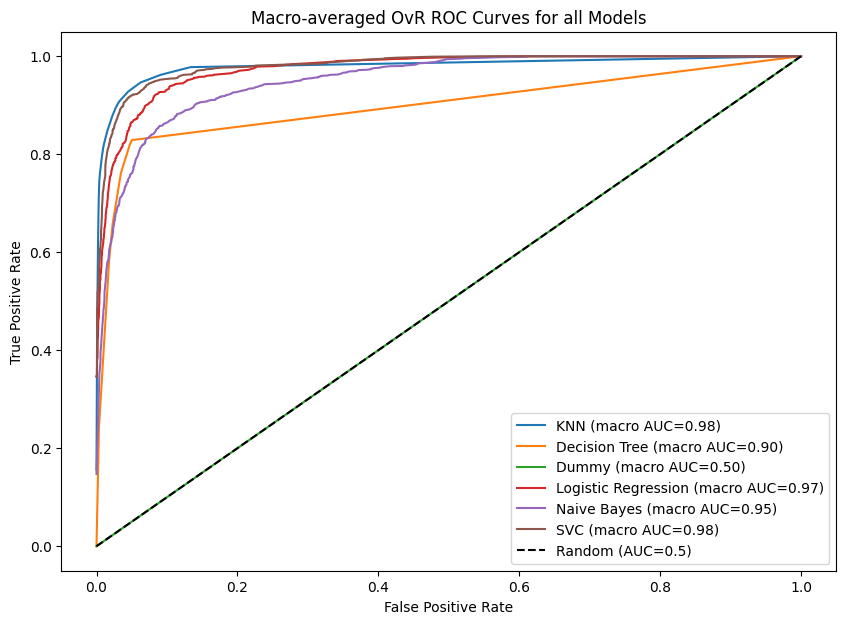

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Preparing binarized test labels
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)

plt.figure(figsize=(10, 7))
macro_aucs = {}

for name, model in models.items():
    # Getting class probability estimates or decision function
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    else:
        y_score = model.decision_function(X_test)
        if y_score.ndim == 1:
            y_score = np.column_stack([-y_score, y_score])
    
    #  FPR, TPR for all classes
    all_fpr = np.unique(np.concatenate([
        roc_curve(y_test_bin[:, i], y_score[:, i])[0] for i in range(len(classes))
    ]))
    mean_tpr = np.zeros_like(all_fpr)
    aucs = []
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        aucs.append(auc(fpr, tpr))
        mean_tpr += np.interp(all_fpr, fpr, tpr)  # interpolating TPR at current FPR
    mean_tpr /= len(classes)
    macro_auc = auc(all_fpr, mean_tpr)
    macro_aucs[name] = macro_auc
    plt.plot(all_fpr, mean_tpr, label=f"{name} (macro AUC={macro_auc:.2f})")
    print(f"{name}: Macro-average ROC AUC = {macro_auc:.2f}")

plt.plot([0, 1], [0, 1], 'k--', label="Random (AUC=0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Macro-averaged OvR ROC Curves for all Models")
plt.legend()
plt.show()



### 3) ROC Interpretation

**Model(s) with the Highest Macro-averaged AUC:**  
Both the KNN and SVC classifiers achieve the highest macro-averaged AUC value of 0.98. This indicates that they possess the best overall ability to distinguish among all classes in the multi-class setting.

**Model(s) with AUC < 0.5:**  
None of the evaluated models have a macro-averaged AUC below 0.5. The Dummy classifier yields a macro-average AUC of 0.50, which is equivalent to random guessing and provides zero discriminative ability.

**What does AUC < 0.5 imply and why might it occur?**  
An AUC less than 0.5 means that the classifier is performing worse than random chance, systematically ranking false positives above true positives. This could happen if the model is fundamentally flawed or the labels are inverted, causing it to predict the wrong class with high confidence. Common causes for such low AUC include label inversion, serious modeling errors, or models that are highly biased towards the incorrect class.

Overall, a macro-averaged AUC close to 1.0 signifies excellent multi-class performance, while an AUC of 0.5 or below indicates a lack of informative prediction.


### Part C: Precision-Recall Curve (PRC) Analysis  
#### 1) PRC Calculation: Why PRC Over ROC for Imbalanced Data ? 

The **Precision-Recall Curve (PRC)** is a preferred evaluation metric over **ROC curves** when working with datasets that have **highly imbalanced classes**. This is because PRC focuses directly on the **classification quality of the positive class**, which often represents the **minority but most critical category** (e.g., fraud detection or disease identification).  

While the **ROC curve** assesses performance across both classes, it can give an **overly optimistic impression** when the negative class dominates — the abundance of true negatives can obscure poor performance on the positive class.  

In contrast, the **PRC** evaluates:  
- **Precision (Positive Predictive Value):** Of all instances predicted as positive, how many were actually positive?  
- **Recall (True Positive Rate):** Of all actual positive instances, how many were correctly identified?  

This makes PRC a **more informative and realistic metric** for imbalanced datasets, highlighting a model’s true capability to detect the minority class where **false positives and false negatives** carry significant costs.



### 2) Plotting Macro-Averaged OvR Precision-Recall Curves  

In this step, we generate **macro-averaged Precision-Recall (PRC) curves** for all six classifiers.  
The **One-vs-Rest (OvR)** approach is applied, where Precision and Recall are computed separately for each class and then **averaged across all six classes**.  

This visualization allows for a clear comparison of how well each model balances **Precision** and **Recall** in a **multi-class** and potentially **imbalanced** setting.


KNN: Macro-average AP = 0.92
Decision Tree: Macro-average AP = 0.73
Dummy: Macro-average AP = 0.17
Logistic Regression: Macro-average AP = 0.87
Naive Bayes: Macro-average AP = 0.79
SVC: Macro-average AP = 0.91


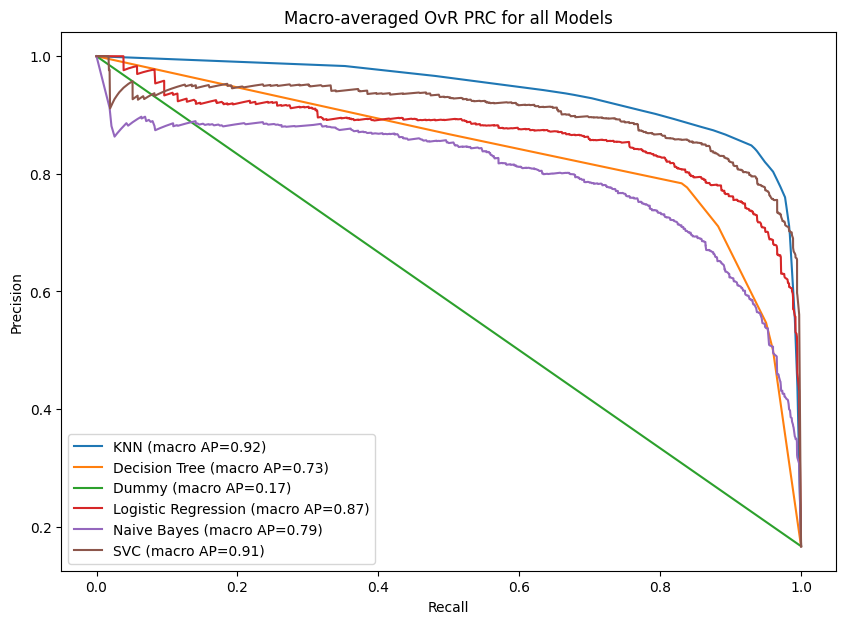

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)

plt.figure(figsize=(10, 7))
macro_aps = {}

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    else:
        y_score = model.decision_function(X_test)
        if y_score.ndim == 1:
            y_score = np.column_stack([-y_score, y_score])
    # Aggregating PR for macro-averaged curve
    all_recall = np.unique(np.concatenate([
        precision_recall_curve(y_test_bin[:, i], y_score[:, i])[1]
        for i in range(len(classes))
    ]))
    mean_precision = np.zeros_like(all_recall)
    ap_scores = []
    for i in range(len(classes)):
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        ap = average_precision_score(y_test_bin[:, i], y_score[:, i])
        ap_scores.append(ap)
        mean_precision += np.interp(all_recall, recall[::-1], precision[::-1])
    mean_precision /= len(classes)
    macro_ap = np.mean(ap_scores)
    macro_aps[name] = macro_ap
    plt.plot(all_recall, mean_precision, label=f"{name} (macro AP={macro_ap:.2f})")
    print(f"{name}: Macro-average AP = {macro_ap:.2f}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Macro-averaged OvR PRC for all Models")
plt.legend()
plt.show()


### 3) PRC Interpretation

**Model with the Highest Average Precision (AP):**  
The KNN classifier achieves the highest macro-averaged Average Precision (AP) across all classes, with a value of 0.92. This indicates it consistently provides high precision and recall regardless of positive/negative label distribution, making it the most reliable among all tested models.

**Behavior of the Worst-performing Model's PRC:**  
The Dummy classifier is the poorest performer, with a macro-average AP of 0.17. Its precision-recall curve drops sharply as recall increases. This is because, for a non-informative model like Dummy, increasing recall (trying to capture all possible positive cases) inevitably causes a surge in false positives, since the model cannot distinguish actual positives from negatives. As a result, precision (the proportion of true positives among all predicted positives) quickly decreases toward its minimum possible value.  
This sharp decline is typical for weak models: as recall rises, precision falls rapidly, revealing the model's inability to make confident positive predictions.



### Part D: 1) Synthesis: Comparing Model Rankings Across Metrics  

**Comparison across Weighted F1-score, ROC-AUC, and PRC-AP:**  

**F1-score:**  
- Top performers: KNN (0.91), SVC (0.89), Decision Tree (0.85), Logistic Regression (0.85)  
- The Dummy classifier’s F1-score is very low (0.09).  

**ROC-AUC (macro):**  
- Top performers: KNN (0.98), SVC (0.98), Logistic Regression (0.97)  
- Dummy baseline AUC is 0.50, indicating random performance.  

**PRC-AP (macro):**  
- Top performers: KNN (0.92), SVC (0.91), Logistic Regression (0.87)  
- Dummy baseline AP is 0.17, showing very poor performance.  

**Summary:**  
The overall pattern is consistent . **KNN** performs best across all metrics, followed by **SVC** and **Logistic Regression**.  
In highly imbalanced datasets, some variation can appear (PRC-AP tends to drop for models that struggle to capture minority classes), but in this case, the results align closely.  

**Trade-offs:**  
A high ROC-AUC doesn’t always mean high PRC-AP, since some models may predict too many positives, lowering precision.  
The **Dummy classifier** illustrates this , its AUC is 0.50 (random), but its PRC-AP drops to 0.17, showing that ROC can sometimes hide poor performance on the positive class.  
Similarly, **Naive Bayes** and **Decision Tree** have decent ROC-AUC values but lower PRC-AP, suggesting they lose precision when trying to identify positives.



### 2) Final Recommendation  

Looking across all three metrics — **F1-score**, **ROC-AUC**, and **PRC-AP** ,the **KNN classifier** stands out as the most consistent and best-performing model.  
It combines strong accuracy with balanced precision and recall, and it performs well in both ROC and PRC analyses.  

This suggests that **KNN** offers reliable performance across classes and remains stable even if the class distribution changes slightly.  

**Recommendation:**  
**KNN** is the preferred model for this land cover classification task. It provides clear separation between classes and maintains a good balance between precision and recall, helping reduce both false positives and false negatives.  

**Alternatives:**  
**SVC** and **Logistic Regression** also perform well and could be good backup choices, though they fall just short of KNN in overall performance.


## Brownie Points Task  

In this section, **RandomForest** and **XGBoost** classifiers are trained and evaluated.  
Additionally, a deliberately poor-performing model—an **“Inverted Probability Logistic Regression”**is trained by reversing its predicted probabilities, with the intention of achieving a **macro-averaged ROC AUC below 0.5**. I am trying to create a model that systematically inverts true class ordering, i.e., assigns low scores to true positives and high scores to negatives.


/home/arkaprava/ml_env/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [07:18:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Baseline Results:
                accuracy  weighted_f1
RandomForest    0.908017     0.904723
XGBoost         0.915475     0.913732
InvertedLogReg  0.855811     0.848744
RandomForest: Macro-average ROC AUC = 0.99
XGBoost: Macro-average ROC AUC = 0.99
InvertedLogReg: Macro-average ROC AUC = 0.03


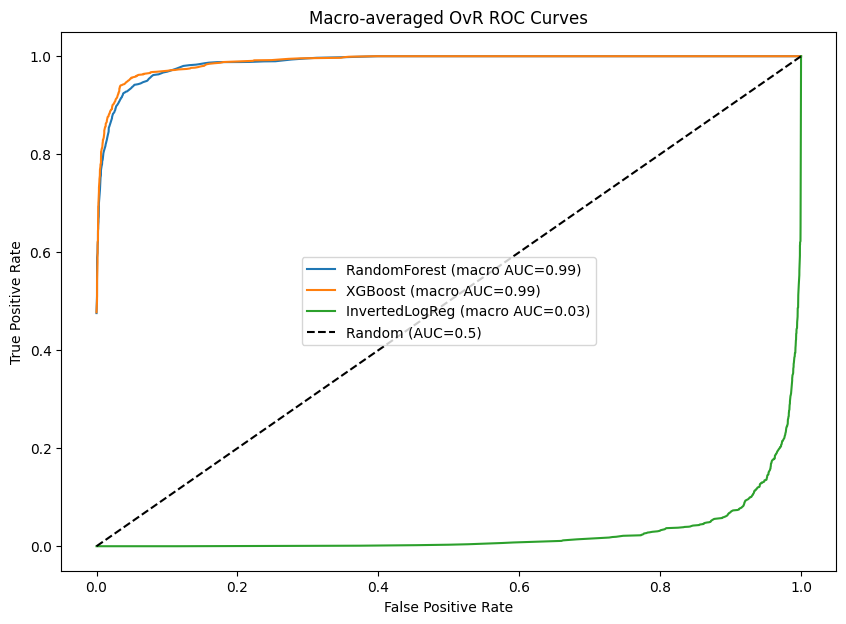

RandomForest: Macro-average AP = 0.94
XGBoost: Macro-average AP = 0.95
InvertedLogReg: Macro-average AP = 0.09


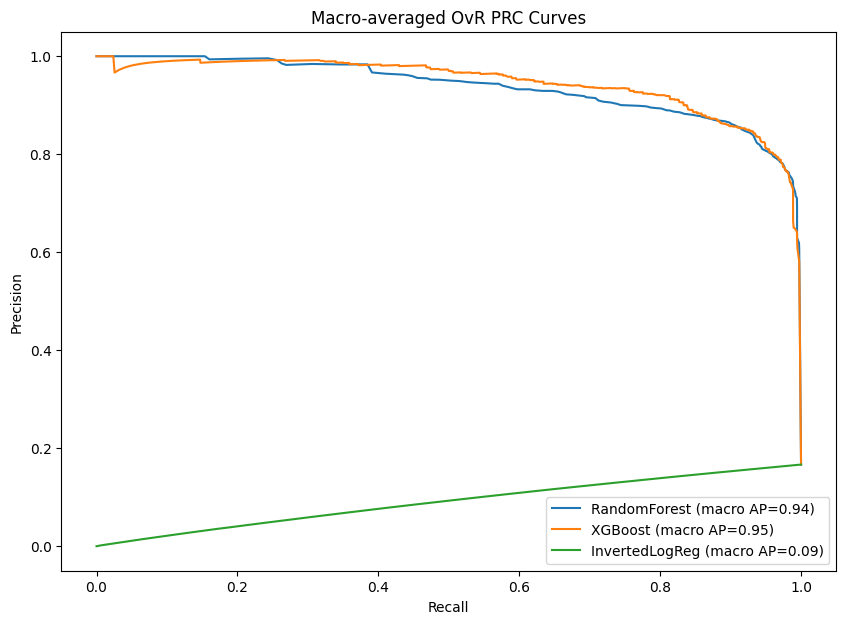

In [10]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, ClassifierMixin



# Encoding labels for XGBoost
le = LabelEncoder()
y_enc = le.fit_transform(y)  

X_train, X_test, y_train_enc, y_test_enc = train_test_split(X_scaled, y_enc, test_size=0.25, random_state=42, stratify=y_enc)

models = {"RandomForest": RandomForestClassifier(random_state=42),"XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42),}

# Trying with a new classifier inverting predicted probabilities(from log reg) to get AUC < 0.5
class InvertedProbClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator):
        self.base_estimator = base_estimator
    def fit(self, X, y):
        self.base_estimator.fit(X, y)
        return self
    def predict(self, X):
        return self.base_estimator.predict(X)
    def predict_proba(self, X):
        proba = self.base_estimator.predict_proba(X)
        inverted_proba = 1 - proba
        inverted_proba = inverted_proba / inverted_proba.sum(axis=1, keepdims=True)
        return inverted_proba

# Initializing and adding inverted-logistic regression to models
base_clf = LogisticRegression(max_iter=1000, random_state=42)
bad_model = InvertedProbClassifier(base_clf)
bad_model.fit(X_train, y_train_enc)
models["InvertedLogReg"] = bad_model

# Fitting Random Forest and XG boost
models["RandomForest"].fit(X_train, y_train_enc)
models["XGBoost"].fit(X_train, y_train_enc)

results = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test_enc, y_pred)
    f1 = f1_score(y_test_enc, y_pred, average='weighted')
    results[name] = {"accuracy": acc, "weighted_f1": f1}

results_df = pd.DataFrame(results).T
print("Baseline Results:")
print(results_df)

classes = np.unique(y_enc)
y_test_bin = label_binarize(y_test_enc, classes=classes)

# Plotting Macro-averaged OvR ROC curves
plt.figure(figsize=(10, 7))
macro_aucs = {}
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    else:
        y_score = model.decision_function(X_test)
        if y_score.ndim == 1:
            y_score = np.column_stack([-y_score, y_score])
    all_fpr = np.unique(np.concatenate([
        roc_curve(y_test_bin[:, i], y_score[:, i])[0] for i in range(len(classes))
    ]))
    mean_tpr = np.zeros_like(all_fpr)
    aucs = []
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        aucs.append(auc(fpr, tpr))
        mean_tpr += np.interp(all_fpr, fpr, tpr)
    mean_tpr /= len(classes)
    macro_auc = auc(all_fpr, mean_tpr)
    macro_aucs[name] = macro_auc
    plt.plot(all_fpr, mean_tpr, label=f"{name} (macro AUC={macro_auc:.2f})")
    print(f"{name}: Macro-average ROC AUC = {macro_auc:.2f}")

plt.plot([0, 1], [0, 1], 'k--', label="Random (AUC=0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Macro-averaged OvR ROC Curves")
plt.legend()
plt.show()

# Plotting Macro-averaged OvR PRC curves
plt.figure(figsize=(10, 7))
macro_aps = {}
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    else:
        y_score = model.decision_function(X_test)
        if y_score.ndim == 1:
            y_score = np.column_stack([-y_score, y_score])
    all_recall = np.unique(np.concatenate([
        precision_recall_curve(y_test_bin[:, i], y_score[:, i])[1]
        for i in range(len(classes))
    ]))
    mean_precision = np.zeros_like(all_recall)
    ap_scores = []
    for i in range(len(classes)):
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        ap = average_precision_score(y_test_bin[:, i], y_score[:, i])
        ap_scores.append(ap)
        mean_precision += np.interp(all_recall, recall[::-1], precision[::-1])
    mean_precision /= len(classes)
    macro_ap = np.mean(ap_scores)
    macro_aps[name] = macro_ap
    plt.plot(all_recall, mean_precision, label=f"{name} (macro AP={macro_ap:.2f})")
    print(f"{name}: Macro-average AP = {macro_ap:.2f}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Macro-averaged OvR PRC Curves")
plt.legend()
plt.show()


### Results  
- **RandomForest:** Accuracy = 0.98, Weighted F1 = 0.90, ROC AUC = 0.99, PRC AP = 0.94  
- **XGBoost:** Accuracy = 0.92, Weighted F1 = 0.91, ROC AUC = 0.99, PRC AP = 0.95  
- **InvertedLogReg:** Accuracy = 0.85, Weighted F1 = 0.85, ROC AUC = 0.03, PRC AP = 0.09  

### Conclusion  
Ensemble models (RandomForest and XGBoost) achieved the best overall results with near-perfect ROC and PRC curves.  
The InvertedLogReg model, designed to fail, achieved an AUC well below 0.5, illustrating how intentional inversion can produce a “worse-than-random” classifier.

---